In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

In [2]:
import scipy.signal as si

In [3]:
import pysm3
import pysm3.units as usm

In [4]:
import skytools

In [5]:
import astropy.units as u 
import astropy as astro

In [6]:
from pixell import enmap, enplot, reproject, utils, curvedsky 
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm

In [7]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [8]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  330.602 GB
     percent :   34.300 % 
        used :  137.291 GB
        free :  314.147 GB
      active :    8.329 GB
    inactive :   96.044 GB
     buffers :   59.297 MB
      cached :   51.641 GB
      shared :    2.782 GB
        slab :   47.201 GB



In [9]:
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

0. Read Planck map

In [10]:
NSIDE = 512
lmax = 2*NSIDE

In [11]:
resol = hp.nside2resol(nside=NSIDE)
amin2rad = np.pi/(60*180)

resol_amin = resol*amin2rad

print(resol)

0.0019986849764579854


In [12]:
# Set the size of the box in degrees and convert to radians
dec_from, dec_to = np.deg2rad([-40,-10])
ra_from, ra_to = np.deg2rad([-25, 25])
box = [[dec_from,ra_from],[dec_to,ra_to]]

In [13]:

fwhm_spsat = 72.8*amin2rad

fwhm_planck = 28*amin2rad

resol_amin = resol*amin2rad

bl_spsat = hp.gauss_beam(fwhm=fwhm_spsat,lmax=lmax,pol=True)
bl_planck = hp.gauss_beam(fwhm=fwhm_planck,lmax=lmax,pol=True)


In [14]:
rGC = hp.rotator.Rotator(coord=['G','C'])  # Transforms galactic to equatorial coordinates


In [15]:
truesky_GC512 = hp.read_map(filename='cmb_030_GC_nside.FITS',field=None)

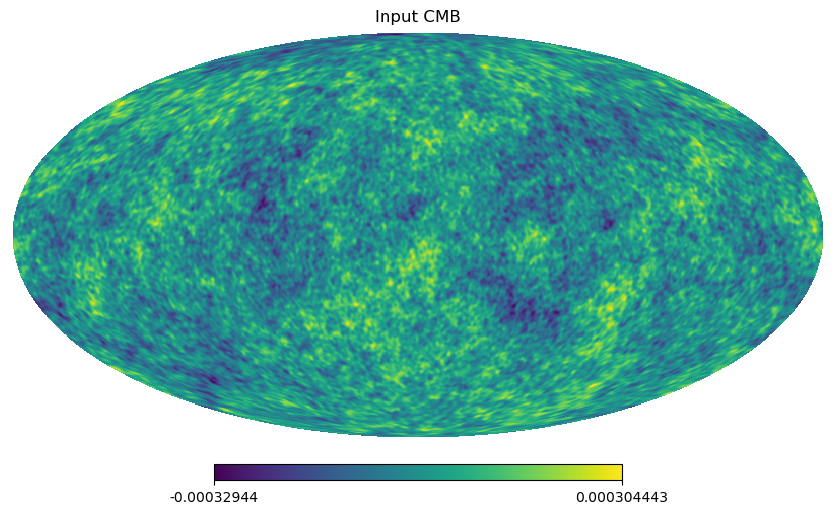

In [16]:
hp.mollview(truesky_GC512[0],title = 'Input CMB')

In [17]:
#truesky_GC512.shape

#hp.write_map(filename='cmb_030_GC_nside_I.FITS', m = truesky_GC512[0], coord = 'C')

Scale-invariant power spectrum

In [18]:
def D_ell(maps, lmax, use_pixel_weights=False):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=use_pixel_weights)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

In [19]:
l_arr = np.arange(0,lmax+1)

Create a telescope and corresponding pointing

1. Start by creating a focalplane with a sample rate and number of detectors

In [20]:
from toast.qarray import to_iso_angles, rotation, mult, to_lonlat_angles
xrot = rotation([0,1,0], np.pi/2)


In [21]:
from toast.instrument_sim import fake_hexagon_focalplane, plot_focalplane

In [22]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=256
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

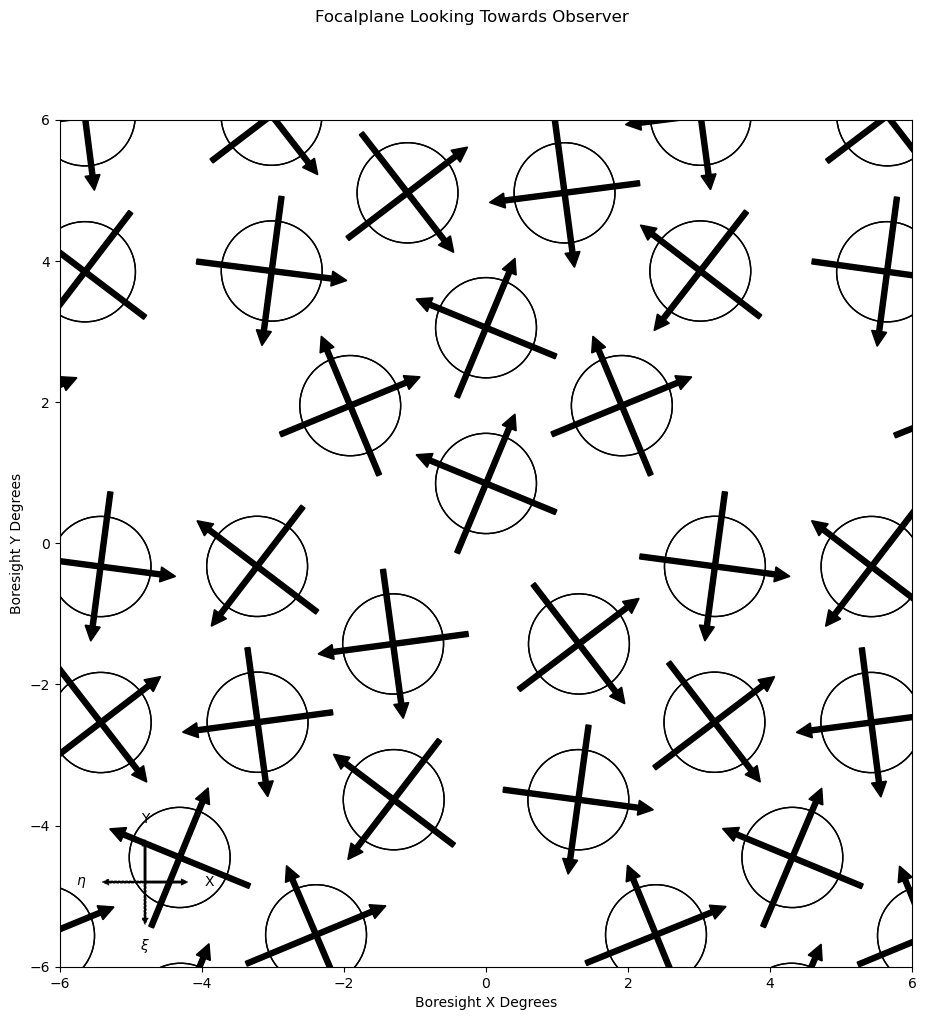

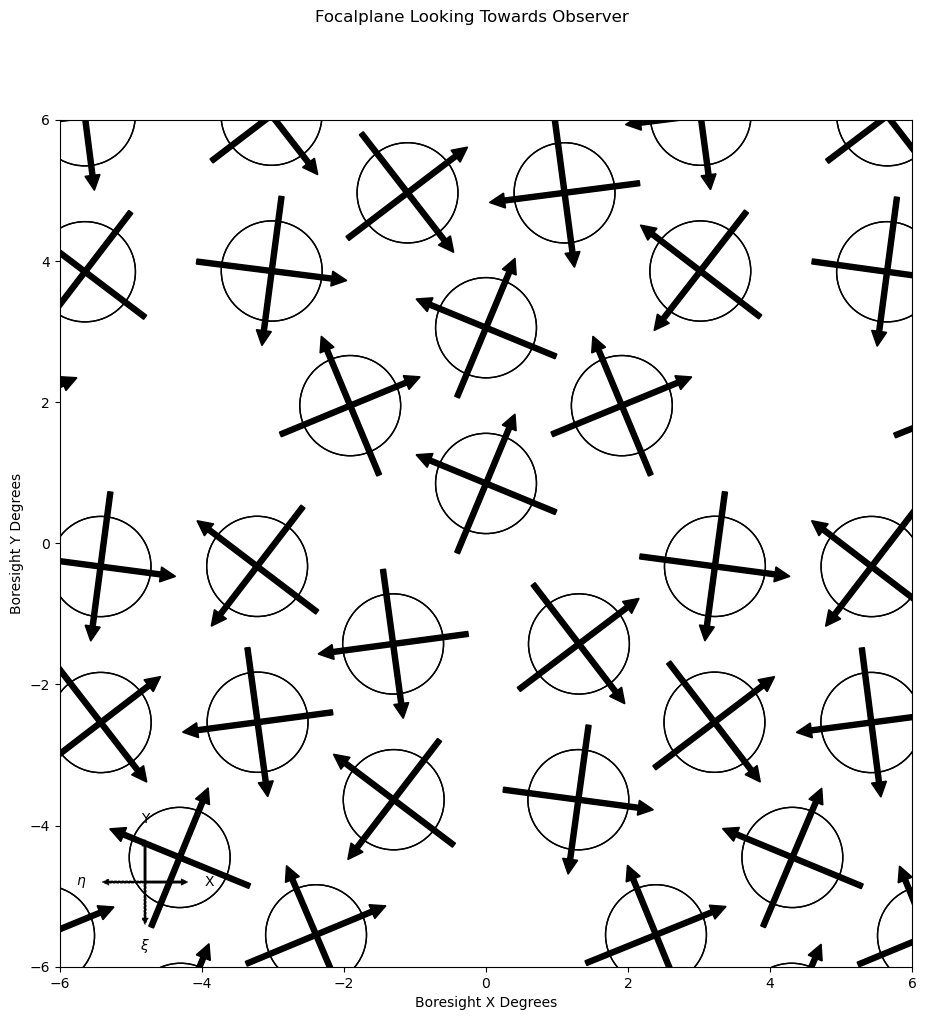

In [23]:
plot_focalplane(focalplane, width=10*u.degree, height = 10*u.degree)

In [24]:
len(focalplane.detectors)

252

In [25]:
focalplane.detector_data

name,pol_leakage,psd_fmin,psd_fknee,psd_alpha,psd_net,bandcenter,bandwidth,elevation_noise_a,elevation_noise_c,pwv_noise_a0,pwv_noise_a1,pwv_noise_a2,wafer,ID,pixel,band,fwhm,pol,card,channel,coax,bias,pol_ang_wafer,quat,gamma,pol_ang,pol_angle,tube,uid,pol_efficiency
,,Hz,Hz,,K s(1/2),GHz,GHz,,,,,,,,,,arcmin,,,,,,,,,,,,,
bytes18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes3,int64,bytes11,bytes8,float64,bytes1,bytes2,int64,int64,int64,float64,float64[4],float64,float64,float64,bytes3,int64,float64
029_000_SAT_f030_A,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290000,ST8-029-000,SAT_f030,85.2,A,29,0,0,0,82.46033391572327,-0.019939423522179353 .. 0.9804515407326396,22.53252739762855,22.53252739762855,0.3932667918844478,ST8,1961233434,1.0
029_000_SAT_f030_B,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290001,ST8-029-000,SAT_f030,85.2,B,29,1,0,0,-187.53966608427672,-0.023316725499726014 .. 0.5551765946451652,112.53252739762856,112.53252739762856,1.9640631186793447,ST8,2650591277,1.0
029_001_SAT_f030_A,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290004,ST8-029-001,SAT_f030,85.2,A,29,4,0,0,127.50000000000001,-0.022151321447949776 .. 0.8311744913919427,67.50000000000001,67.50000000000001,1.1780972450961724,ST8,3385452255,1.0
029_001_SAT_f030_B,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290005,ST8-029-001,SAT_f030,85.2,B,29,5,0,0,-142.50000000000003,-0.005197434001702075 .. 0.19502107687159004,157.49999999999997,157.49999999999997,2.748893571891069,ST8,3447764217,1.0
029_002_SAT_f030_A,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290008,ST8-029-002,SAT_f030,85.2,A,29,8,0,0,127.50000000000001,-0.006143239211862963 .. 0.8314469176048047,67.50000000000001,67.50000000000001,1.1780972450961724,ST8,3734263641,1.0
029_002_SAT_f030_B,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290009,ST8-029-002,SAT_f030,85.2,B,29,9,0,0,-142.50000000000006,-0.0014414074769919048 .. 0.19508499708804372,157.49999999999997,157.49999999999997,2.7488935718910685,ST8,40520422,1.0
029_003_SAT_f030_A,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290012,ST8-029-003,SAT_f030,85.2,A,29,12,0,0,82.53966608427672,-0.013433191406433311 .. 0.9805622640628396,22.467472602371462,22.467472602371462,0.39213137151300065,ST8,747480080,1.0
029_003_SAT_f030_B,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290013,ST8-029-003,SAT_f030,85.2,B,29,13,0,0,172.53966608427672,0.00441265768506623 .. 0.5556484944476916,112.46747260237146,112.46747260237146,1.9629276983078972,ST8,1578398947,1.0


Print focalplane information

In [26]:
for detec in focalplane.detectors:
    q = focalplane[detec]["quat"]
    print(np.degrees(to_iso_angles(mult(xrot,q))))

[88.08882932  1.94993571 22.5       ]
[ 88.08882932   1.94993571 112.5       ]
[90.          3.05321419 67.5       ]
[ 90.           3.05321419 157.5       ]
[90.          0.84665724 67.5       ]
[ 90.           0.84665724 157.5       ]
[91.91117068  1.94993571 22.5       ]
[ 91.91117068   1.94993571 112.5       ]
[ 88.89786687   7.17209843 -97.5670297 ]
[88.89786687  7.17209843 -7.5670297 ]
[ 88.89628048   4.96503074 -52.50613882]
[88.89628048  4.96503074 37.49386118]
[ 86.9857875    6.06983805 -52.54583908]
[86.9857875   6.06983805 37.45416092]
[ 86.98572831   3.86012121 -97.44803143]
[86.98572831  3.86012121 -7.44803143]
[ 93.01427169   3.86012121 142.44803143]
[  93.01427169    3.86012121 -127.55196857]
[  91.10371952    4.96503074 -172.49386118]
[ 91.10371952   4.96503074 -82.49386118]
[  93.0142125     6.06983805 -172.45416092]
[ 93.0142125    6.06983805 -82.45416092]
[ 91.10213313   7.17209843 142.5670297 ]
[  91.10213313    7.17209843 -127.4329703 ]
[83.78902672 -5.58231042 22.

In [27]:
#lonlat_angles = np.array([np.degrees(to_lonlat_angles(mult(xrot,focalplane[detec]["quat"])))for detec in focalplane.detectors])
#
#lonlat_angles.shape
#
#np.where(np.abs(lonlat_angles[:,0]-lonlat_angles[0,0])<1e-4)

Define the schedule, site and telescope

In [28]:
focalplane._det_to_row = {'029_000_SAT_f030_A': 0,
  '029_003_SAT_f030_A': 6}
#focalplane._det_to_row = {'029_000_SAT_f030_A': 0,'029_000_SAT_f030_B': 1,
#  '029_003_SAT_f030_A': 6,'029_003_SAT_f030_B': 7}
#=focalplane._det_to_row[:4]

In [29]:
focalplane.detectors

['029_000_SAT_f030_A', '029_003_SAT_f030_A']

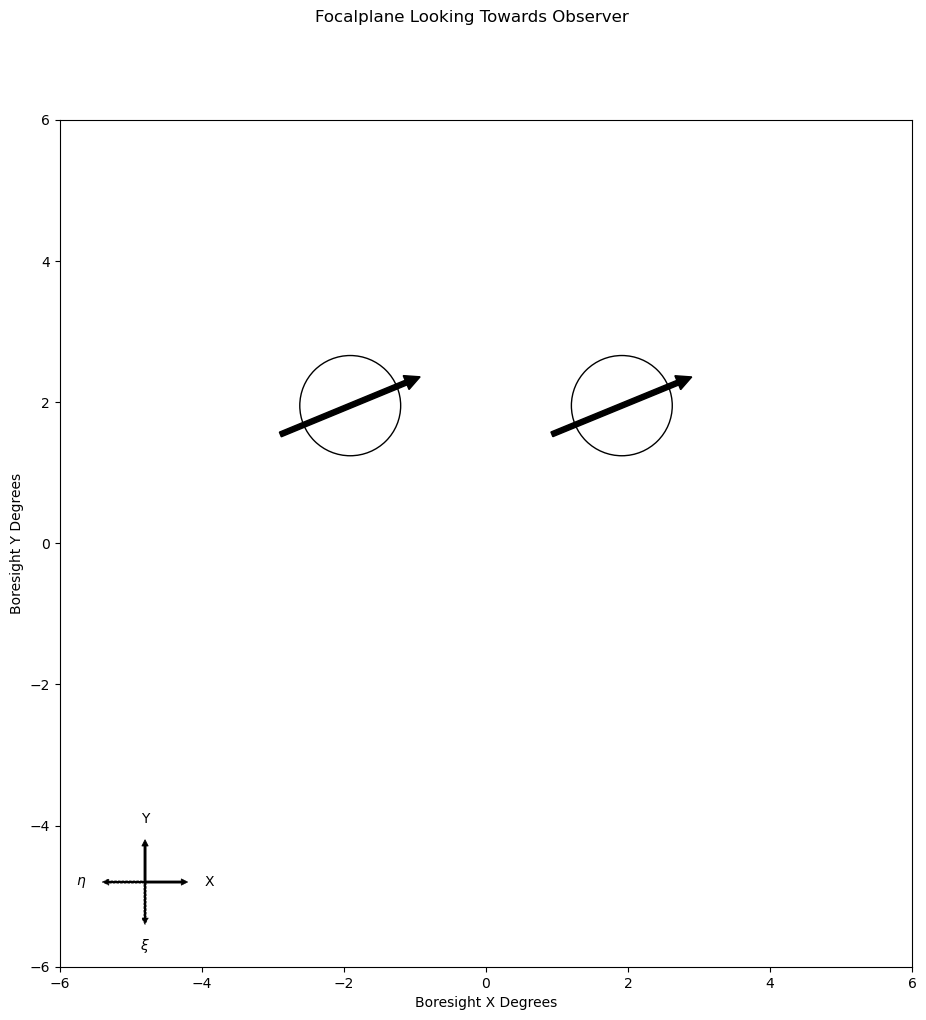

<Figure size 640x480 with 0 Axes>

In [30]:
plot_focalplane(focalplane, width=10*u.degree, height = 10*u.degree)
plt.savefig('two_detectors.png')

In [31]:
focalplane

<Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>

In [32]:
schedule = toast.schedule.GroundSchedule()
#for i in range(7):
#    schedule.read("POLE_DEEP-169-"+str(i+1)+".txt", comm=comm)
schedule.read("POLE_DEEP-169-1.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP-169-1.txt
TOAST INFO: Loaded 1 scans from POLE_DEEP-169-1.txt totaling 84.0 minutes.


Print schedule information

In [33]:
schedule

<GroundSchedule site=SOUTH_POLE at -89.991 deg, -44.65 deg, 2843.0 m telescope SAT with 1 scans
  <GroundScan 'POLE_DEEP' at 2027-05-28T06:00:00+00:00 with El = 52.6 deg, Az 63.59 deg -- 134.26 deg>
>

Print telescope information

In [34]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

In [35]:
telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [36]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [37]:
data = toast.Data(comm=toast_comm)

In [38]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [39]:
sim_ground

<SimGround
  API = 0 # Internal interface version for this operator
  azimuth = azimuth # Observation shared key for Azimuth
  boresight_azel = boresight_azel # Observation shared key for boresight AZ/EL
  boresight_radec = boresight_radec # Observation shared key for boresight RA/DEC
  det_data = signal # Observation detdata key to initialize
  det_data_units = K # Output units if creating detector data
  det_flags = flags # Observation detdata key for flags to initialize
  detset_key = pixel # If specified, use this column of the focalplane detector_data to group detectors
  distribute_time = False # Distribute observation data along the time axis rather than detector axis
  el_mod_amplitude = 1.0 deg # Range of elevation modulation
  el_mod_rate = 0.0 Hz # Modulate elevation continuously at this rate
  el_mod_sine = False # Modulate elevation with a sine wave instead of a triangle wave
  el_mod_step = 0.0 deg # Amount to step elevation after each left-right scan pair
  elevation = e

In [40]:
sim_ground.apply(data)

In [41]:
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-1'
  uid = '3569251122'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 6, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>
  session = <Session 'POLE_DEEP-169-1': uid = 527578977, start = 2027-05-28 06:00:00+00:00, end = 2027-05-28 07:23:59.900000+00:00>
  scan_el = 52.6 deg
  scan_min_az = 1.0861993598757675 rad
  scan_max_az = 2.366934565195013 rad
  scan_min_el = 0.9180431865490174 rad
  scan_max_el = 0.9180431865490174 rad
  50400 total samples (50400 local)
  shared:  <SharedDataManager
    times (column): shape=(50400,),

In [42]:
focalplane.detectors

['029_000_SAT_f030_A', '029_003_SAT_f030_A']

1. Create a focalplane with only two detectors in the same row with the same polarization
2. Two timestreams and see where scans overlap (?)
3. Fit a step function and substract it. How to adjust level at the end of overlap?
4. bin 

In [43]:
pointing = toast.ops.PointingDetectorSimple() ##boresight pointing into detector frame (RA/DEC by default)
weights = toast.ops.StokesWeights(detector_pointing = pointing,mode = "I")
pixels = toast.ops.PixelsHealpix(detector_pointing = pointing, nside = NSIDE)

pixels_wcs = toast.ops.pixels_wcs.PixelsWCS(detector_pointing = pointing, resolution=(resol_amin/60*u.degree,resol_amin/60*u.degree))

In [44]:
pointing.apply(data)

In [45]:
scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='cmb_030_GC_nside_I.FITS',pixel_pointing = pixels, stokes_weights = weights)
#scan_map = toast.ops.ScanWCSMap(name="scan_wcs_map", file = "cmb_030_GC_nside_I.FITS",pixel_pointing=pixels_wcs,stokes_weights=weights)
scan_map.apply(data)

TOAST INFO: Pixel data in cmb_030_GC_nside_I.FITS does not have TUNIT1 key.  Assuming 'K'.


2. Noise simulation

In [46]:
ob = data.obs[0]

In [47]:
ob.detdata.create(name = 'noise',units = u.K)
ob.detdata.create(name = 'total',units = u.K)

In [48]:
noise_model = toast.ops.DefaultNoiseModel()
sim_noise = toast.ops.SimNoise() ###Need to instantiate Noise Model

In [49]:
sim_noise.det_data= 'noise'

In [50]:
noise_model.apply(data) ## Read detector noise from the focalplane
sim_noise.apply(data)

In [51]:
step_0 = 15*u.second


In [52]:
focalplane.detector_data

name,pol_leakage,psd_fmin,psd_fknee,psd_alpha,psd_net,bandcenter,bandwidth,elevation_noise_a,elevation_noise_c,pwv_noise_a0,pwv_noise_a1,pwv_noise_a2,wafer,ID,pixel,band,fwhm,pol,card,channel,coax,bias,pol_ang_wafer,quat,gamma,pol_ang,pol_angle,tube,uid,pol_efficiency
,,Hz,Hz,,K s(1/2),GHz,GHz,,,,,,,,,,arcmin,,,,,,,,,,,,,
bytes18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes3,int64,bytes11,bytes8,float64,bytes1,bytes2,int64,int64,int64,float64,float64[4],float64,float64,float64,bytes3,int64,float64
029_000_SAT_f030_A,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290000,ST8-029-000,SAT_f030,85.2,A,29,0,0,0,82.46033391572327,-0.019939423522179353 .. 0.9804515407326396,22.53252739762855,22.53252739762855,0.3932667918844478,ST8,1961233434,1.0
029_000_SAT_f030_B,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290001,ST8-029-000,SAT_f030,85.2,B,29,1,0,0,-187.53966608427672,-0.023316725499726014 .. 0.5551765946451652,112.53252739762856,112.53252739762856,1.9640631186793447,ST8,2650591277,1.0
029_001_SAT_f030_A,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290004,ST8-029-001,SAT_f030,85.2,A,29,4,0,0,127.50000000000001,-0.022151321447949776 .. 0.8311744913919427,67.50000000000001,67.50000000000001,1.1780972450961724,ST8,3385452255,1.0
029_001_SAT_f030_B,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290005,ST8-029-001,SAT_f030,85.2,B,29,5,0,0,-142.50000000000003,-0.005197434001702075 .. 0.19502107687159004,157.49999999999997,157.49999999999997,2.748893571891069,ST8,3447764217,1.0
029_002_SAT_f030_A,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290008,ST8-029-002,SAT_f030,85.2,A,29,8,0,0,127.50000000000001,-0.006143239211862963 .. 0.8314469176048047,67.50000000000001,67.50000000000001,1.1780972450961724,ST8,3734263641,1.0
029_002_SAT_f030_B,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290009,ST8-029-002,SAT_f030,85.2,B,29,9,0,0,-142.50000000000006,-0.0014414074769919048 .. 0.19508499708804372,157.49999999999997,157.49999999999997,2.7488935718910685,ST8,40520422,1.0
029_003_SAT_f030_A,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290012,ST8-029-003,SAT_f030,85.2,A,29,12,0,0,82.53966608427672,-0.013433191406433311 .. 0.9805622640628396,22.467472602371462,22.467472602371462,0.39213137151300065,ST8,747480080,1.0
029_003_SAT_f030_B,0.0,1e-05,0.05,1.0,0.0001872,24.75,6.5,0.2062,0.73082,0.965911,0.105767,0.001339,029,290013,ST8-029-003,SAT_f030,85.2,B,29,13,0,0,172.53966608427672,0.00441265768506623 .. 0.5556484944476916,112.46747260237146,112.46747260237146,1.9629276983078972,ST8,1578398947,1.0


In [53]:
ob.detdata['quats'][0].shape

(50400, 4)

In [54]:
ob.detdata['total'][:,:] = ob.detdata['signal'][:,:]+ob.detdata['noise'][:,:]


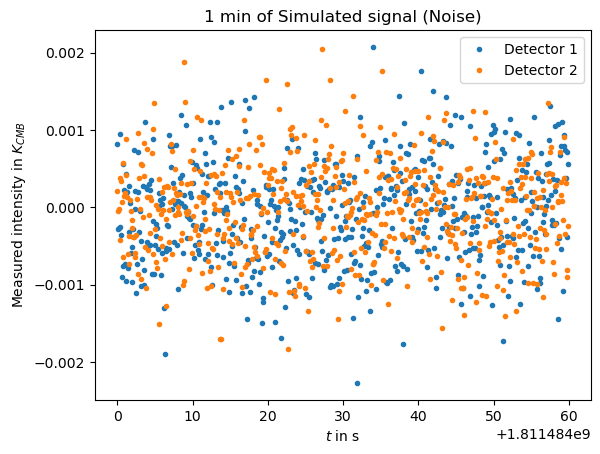

In [55]:
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][0][0:600],".", label = 'Detector 1') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][1][0:600],".", label = 'Detector 2') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Simulated signal (Noise)')
plt.legend(loc = 'best')
plt.show()

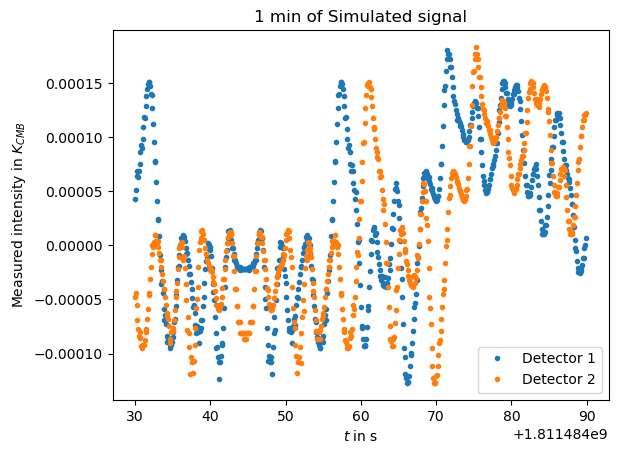

In [56]:
plt.plot(ob.shared["times"][300:900],ob.detdata["signal"][0][300:900],".", label = 'Detector 1') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][300:900],ob.detdata["signal"][1][300:900],".", label = 'Detector 2') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

In [57]:
ob.detdata['quats']

<DetectorData 2 detectors each with shape (50400, 4), type float64, units :
  029_000_SAT_f030_A = [ [0.81171596 0.4778731  0.25948754 0.21312136] [0.81102766 0.47904088 0.25979585 0.21274416] ... [ 0.2520978   0.90723693  0.33548692 -0.02857249] [ 0.25339775  0.90687595  0.33552423 -0.02809052] ]
  029_003_SAT_f030_A = [ [0.80598921 0.48748555 0.27825446 0.18791934] [0.80528699 0.488645   0.27852649 0.18751514] ... [ 0.24125608  0.91013356  0.33148917 -0.05972725] [ 0.24256031  0.90978811  0.33157112 -0.05925101] ]
>

In [58]:
quats_1 = ob.detdata['quats'][0]
quats_2 = ob.detdata['quats'][1]

In [59]:
boresight_radec = ob.shared['boresight_radec']

In [168]:
#iso_ang1 = np.degrees(to_lonlat_angles(quats_1))
#iso_ang2 = np.degrees(to_lonlat_angles(quats_2))
#iso_ang1 = np.degrees(to_lonlat_angles(mult(xrot,quats_1)))
#iso_ang2 = np.degrees(to_lonlat_angles(mult(xrot,quats_2)))
iso_ang1 = to_iso_angles(mult(xrot,quats_1))
iso_ang2 = to_iso_angles(mult(xrot,quats_2))
#iso_ang1 = to_iso_angles(quats_1)
#iso_ang2 = to_iso_angles(quats_2)

In [169]:
iso_ang1

(array([2.24586419, 2.24622195, 2.24657314, ..., 1.68657489, 1.68837404,
        1.6901726 ]),
 array([-3.01574743, -3.01804424, -3.02034337, ...,  2.46302326,
         2.46329218,  2.46356523]),
 array([-1.0199492 , -1.02361139, -1.02727568, ..., -2.6432874 ,
        -2.64104088, -2.63879339]))

In [170]:
#lambda1,phi1,psi1 = iso_ang1
#lambda2,phi2,psi2 = iso_ang2
#th1 = 90-lambda1
#th2 = 90-lambda2
th1,phi1,psi1 = iso_ang1
th2,phi2,psi2 = iso_ang2


In [171]:
print(phi1)

[-3.01574743 -3.01804424 -3.02034337 ...  2.46302326  2.46329218
  2.46356523]


In [172]:
pix_arr1 = hp.ang2pix(nside=NSIDE,theta= th1, phi = phi1, lonlat = False)

In [173]:
pix_arr2 = hp.ang2pix(nside=NSIDE,theta= th2, phi = phi2, lonlat = False)

In [174]:
time = ob.shared["times"]

In [175]:
N_time = time.shape[0]
print(N_time)

50400


In [176]:
npix = hp.nside2npix(NSIDE)

In [177]:
npix

3145728

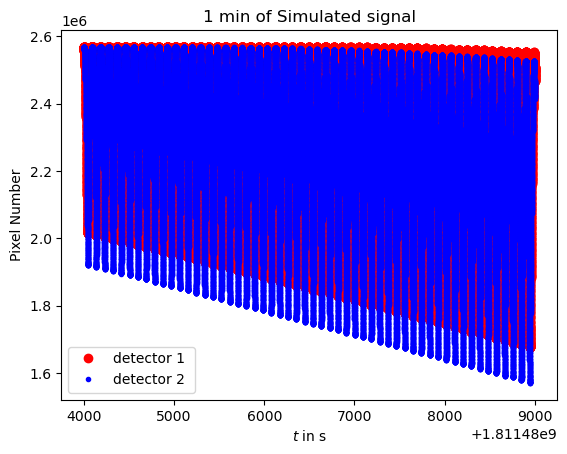

In [178]:
plt.plot(time[0:50000], pix_arr1[0:50000],'ro', label = 'detector 1 ')
plt.plot(time[0:50000], pix_arr2[0:50000],'b.', label = 'detector 2')
plt.xlabel('$t$ in s')
plt.ylabel('Pixel Number')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

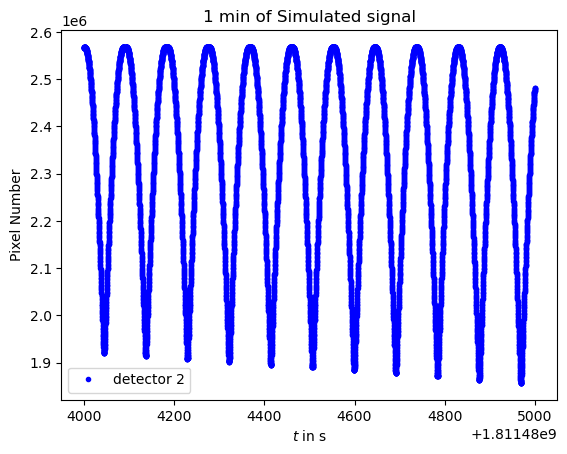

In [179]:
plt.plot(time[0:10000], pix_arr2[0:10000],'b.', label = 'detector 2')
plt.xlabel('$t$ in s')
plt.ylabel('Pixel Number')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

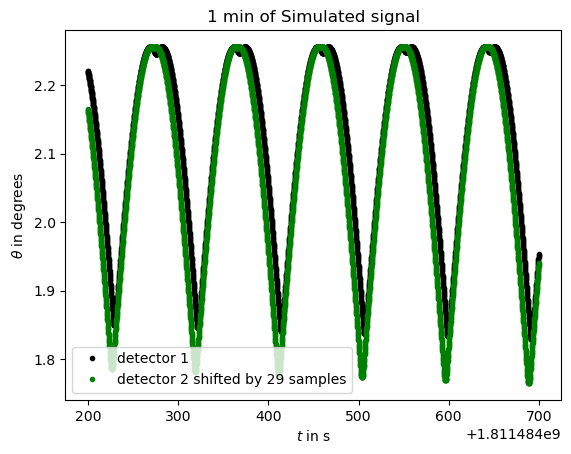

In [180]:
plt.plot(time[2000:7000], th1[2000:7000],'k.', label = 'detector 1')
plt.plot(time[2000:7000], th2[2029:7029],'g.', label = 'detector 2 shifted by 29 samples')

#plt.plot(time[2000:7000], np.degrees(th1[2029:7029]),'r', label = 'detector 1 shifted by 29 samples')
#plt.plot(time[2000:7000], np.degrees(th2[2000:7000]),'b', label = 'detector 2')


plt.xlabel('$t$ in s')
plt.ylabel(r'$\theta$ in degrees')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

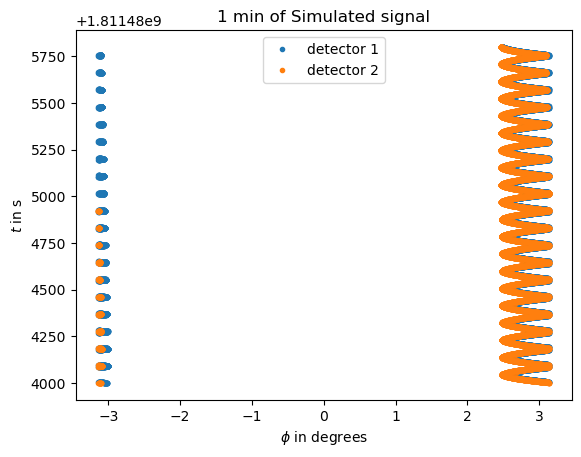

In [182]:
plt.plot(phi1[:18000],time[:18000],'.',  label = 'detector 1')
plt.plot(phi2[:18000],time[:18000],'.',  label = 'detector 2')
plt.ylabel('$t$ in s')
plt.xlabel(r'$\phi$ in degrees')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

In [74]:
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-1'
  uid = '3569251122'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 6, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>
  session = <Session 'POLE_DEEP-169-1': uid = 527578977, start = 2027-05-28 06:00:00+00:00, end = 2027-05-28 07:23:59.900000+00:00>
  scan_el = 52.6 deg
  scan_min_az = 1.0861993598757675 rad
  scan_max_az = 2.366934565195013 rad
  scan_min_el = 0.9180431865490174 rad
  scan_max_el = 0.9180431865490174 rad
  noise_model = <AnalyticNoise model with 2 detectors>
  50400 total samples (50400 local)
  shared: 

In [75]:
np.where(ob.detdata['flags'][0]!=0)

(array([], dtype=int64),)

In [76]:
#print(ob.intervals['throw'])

In [77]:
ob.intervals

<IntervalsManager 13 lists
  throw_leftright: 55 intervals
  throw_rightleft: 55 intervals
  throw: 110 intervals
  scan_leftright: 55 intervals
  turn_leftright: 55 intervals
  scan_rightleft: 55 intervals
  turn_rightleft: 54 intervals
  elnod: 0 intervals
  scanning: 110 intervals
  turnaround: 109 intervals
  sun_up: 0 intervals
  sun_close: 0 intervals>

In [78]:
#ob.intervals['throw']

In [79]:
#throw_start = np.array([inter[2] for inter in ob.intervals['throw']])
#throw_end = np.array([inter[3] for inter in ob.intervals['throw']])
throw_lr_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['throw_leftright']])
throw_rl_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['throw_rightleft']])
scan_lr_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['scan_leftright']])
scan_rl_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['scan_rightleft']])

In [80]:
#for interval in throw_lr_sample:
#    print(interval[0], interval[1])

In [81]:
RA_lr1 =[phi1[interval[0]:interval[1]] for interval in throw_lr_sample]
RA_rl1 =[phi1[interval[0]:interval[1]] for interval in throw_rl_sample]

RA_lr2 = [phi2[interval[0]:interval[1]] for interval in throw_lr_sample]
RA_rl2 = [phi2[interval[0]:interval[1]] for interval in throw_rl_sample]

In [82]:
RA_lr1scan =[phi1[interval[0]:interval[1]] for interval in scan_lr_sample]
RA_rl1scan =[phi1[interval[0]:interval[1]] for interval in scan_rl_sample]

RA_lr2scan = [phi2[interval[0]:interval[1]] for interval in scan_lr_sample]
RA_rl2scan= [phi2[interval[0]:interval[1]] for interval in scan_rl_sample]

In [83]:
signal_lr1 = [ob.detdata["signal"][0,interval[0]:interval[1]] for interval in throw_lr_sample]
signal_lr2 = [ob.detdata["signal"][1,interval[0]:interval[1]] for interval in throw_lr_sample]

signal_rl1 = [ob.detdata["signal"][0,interval[0]:interval[1]] for interval in throw_rl_sample]
signal_rl2 = [ob.detdata["signal"][1,interval[0]:interval[1]] for interval in throw_rl_sample]

In [84]:
signal_lr1scan = [ob.detdata["signal"][0,interval[0]:interval[1]] for interval in scan_lr_sample]
signal_lr2scan = [ob.detdata["signal"][1,interval[0]:interval[1]] for interval in scan_lr_sample]

signal_rl1scan = [ob.detdata["signal"][0,interval[0]:interval[1]] for interval in scan_rl_sample]
signal_rl2scan = [ob.detdata["signal"][1,interval[0]:interval[1]] for interval in scan_rl_sample]

In [85]:
total_lr1 = [ob.detdata["total"][0,interval[0]:interval[1]] for interval in throw_lr_sample]
total_lr2 = [ob.detdata["total"][1,interval[0]:interval[1]] for interval in throw_lr_sample]

total_rl1 = [ob.detdata["total"][0,interval[0]:interval[1]] for interval in throw_rl_sample]
total_rl2 = [ob.detdata["total"][1,interval[0]:interval[1]] for interval in throw_rl_sample]

In [86]:
total_lr1scan = [ob.detdata["total"][0,interval[0]:interval[1]] for interval in scan_lr_sample]
total_lr2scan = [ob.detdata["total"][1,interval[0]:interval[1]] for interval in scan_lr_sample]

total_rl1scan = [ob.detdata["total"][0,interval[0]:interval[1]] for interval in scan_rl_sample]
total_rl2scan = [ob.detdata["total"][1,interval[0]:interval[1]] for interval in scan_rl_sample]

In [87]:
noise_lr1 = [ob.detdata["noise"][0,interval[0]:interval[1]] for interval in throw_lr_sample]
noise_lr2 = [ob.detdata["noise"][1,interval[0]:interval[1]] for interval in throw_lr_sample]

noise_rl1 = [ob.detdata["noise"][0,interval[0]:interval[1]] for interval in throw_rl_sample]
noise_rl2 = [ob.detdata["noise"][1,interval[0]:interval[1]] for interval in throw_rl_sample]

In [88]:
noise_lr1scan = [ob.detdata["noise"][0,interval[0]:interval[1]] for interval in scan_lr_sample]
noise_lr2scan = [ob.detdata["noise"][1,interval[0]:interval[1]] for interval in scan_lr_sample]

noise_rl1scan = [ob.detdata["noise"][0,interval[0]:interval[1]] for interval in scan_rl_sample]
noise_rl2scan = [ob.detdata["noise"][1,interval[0]:interval[1]] for interval in scan_rl_sample]

Text(0.5, 1.0, 'First left-right throw (signal only)')

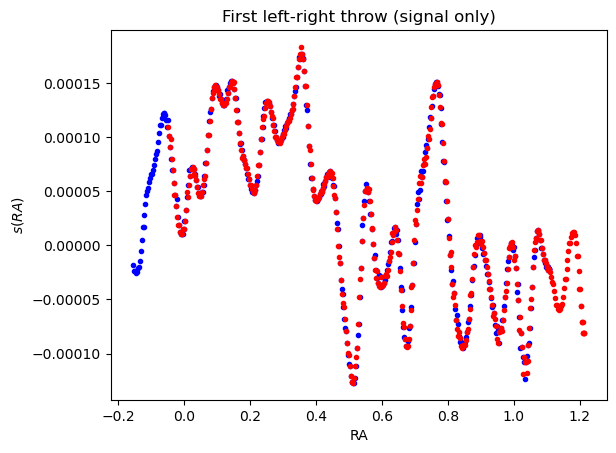

In [89]:

plt.plot(RA_lr1[0],signal_lr1[0],'b.')
plt.plot(RA_lr2[0],signal_lr2[0],'r.')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First left-right throw (signal only)')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

In [90]:
print(RA_lr1scan[0].shape)
print(RA_lr2scan[0].shape)

(429,)
(429,)


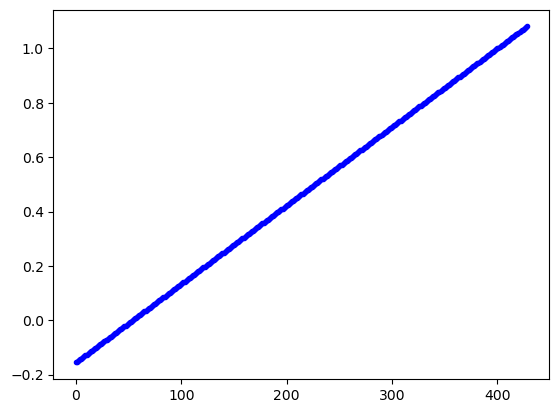

In [91]:
plt.plot(np.arange(0,RA_lr1scan[0].shape[0]),RA_lr1scan[0],'b.')

Text(0.5, 1.0, 'First left-right scan')

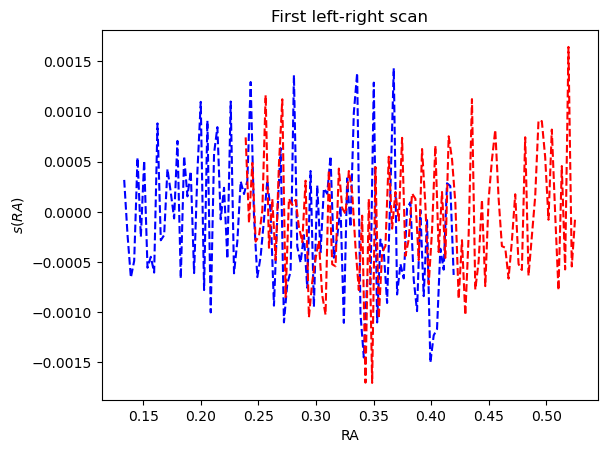

In [92]:

plt.plot(RA_lr1scan[0][100:200],noise_lr1scan[0][100:200],'b--')
plt.plot(RA_lr2scan[0][100:200],noise_lr2scan[0][100:200],'r--')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First left-right scan')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

In [93]:
RA_lr1scan[0].shape

(429,)

Text(0.5, 1.0, '1st left-right throw')

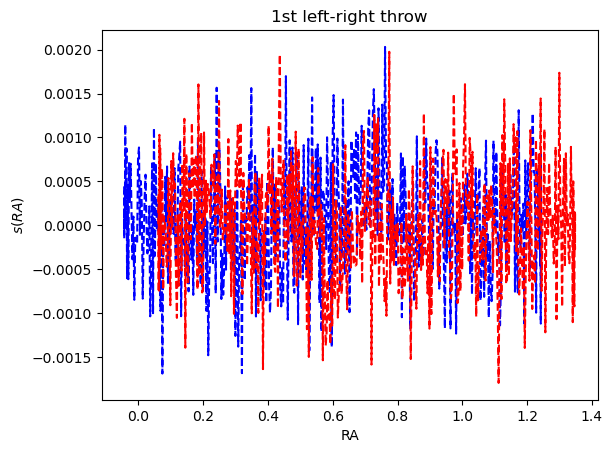

In [94]:
plt.plot(RA_lr1[20],total_lr1[20],'b--')
plt.plot(RA_lr2[20],total_lr2[20],'r--')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('1st left-right throw')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

In [95]:
psd_detector = np.array([si.welch(TOD,fs = 10,nperseg=4096) for TOD in ob.detdata["noise"]])

In [96]:
psd_detector.shape

(2, 2, 2049)

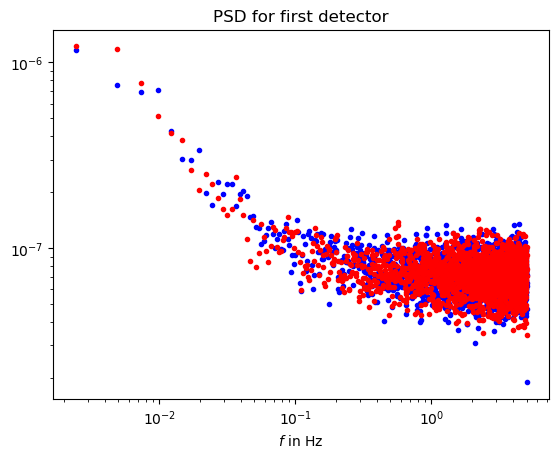

In [97]:
plt.plot(psd_detector[0,0],psd_detector[0,1],".b", label = 'First') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(psd_detector[1,0],psd_detector[1,1],".r", label = 'Second') ##Detdata has several data, signal is under "signal", detdata is a 2D array

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$f$ in Hz')
plt.title('PSD for first detector')
plt.show()

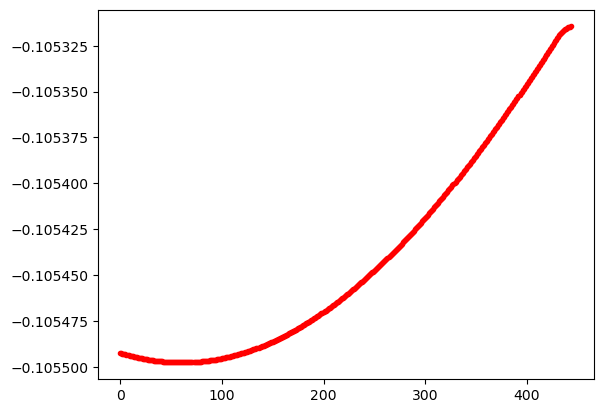

In [98]:
#plt.plot(np.arange(0,RA_lr1[0].shape[0]),RA_lr1[0],'b')
#plt.plot(np.arange(0,RA_lr1[0].shape[0]),RA_lr2[0],'r')
plt.plot(np.arange(0,RA_lr1[0].shape[0]),RA_lr1[0]-RA_lr2[0],'r.')


In [99]:
def combine_arrays(x1, y1, x2, y2):
    combined_x = np.union1d(x1, x2)
    combined_y = np.zeros_like(combined_x, dtype=float)
    
    for i, x in enumerate(combined_x):
        if x in x1 and x in x2:
            combined_y[i] = (y1[np.where(x1 == x)] + y2[np.where(x2 == x)]) / 2
        elif x in x1:
            combined_y[i] = y1[np.where(x1 == x)]
        else:
            combined_y[i] = y2[np.where(x2 == x)]
    
    return combined_x, combined_y

In [100]:
# Example usage:
x1 = np.array([1, 2, 3, 4])
y1 = np.array([10, 20, 30, 40])
x2 = np.array([3, 4, 5, 6])
y2 = np.array([300, 400, 500, 600])

In [101]:
np.union1d(x1,x2)

array([1, 2, 3, 4, 5, 6])

In [102]:
combined_x, combined_y = combine_arrays(x1, y1, x2, y2)

/tmp/ipykernel_1833331/3925583138.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  combined_y[i] = y1[np.where(x1 == x)]
/tmp/ipykernel_1833331/3925583138.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  combined_y[i] = (y1[np.where(x1 == x)] + y2[np.where(x2 == x)]) / 2
/tmp/ipykernel_1833331/3925583138.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  combined_y[i] = y2[np.where(x2 == x)]


Text(0.5, 1.0, 'First right-left throw')

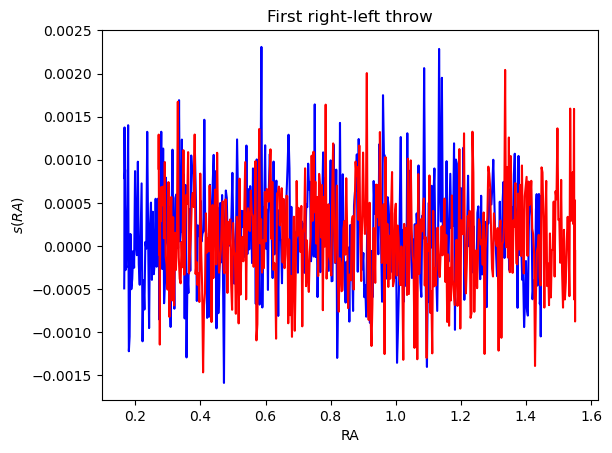

In [103]:
#plt.plot(RA_rl1[0],signal_rl1[0],'b--')
#plt.plot(RA_rl2[0],signal_rl2[0],'r--')
plt.plot(RA_rl1[50],total_rl1[50],'b')
plt.plot(RA_rl2[50],total_rl2[50],'r')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First right-left throw')

## Destriping

In [104]:
templates = [toast.templates.Offset(name="baselines", step_time = step_0)]

In [105]:
templates

[<Offset
   data = None # This must be an instance of a Data class (or None)
   debug_plots = None # If not None, make debugging plots in this directory
   det_data = signal # Observation detdata key for the timestream data
   det_data_units = K # Desired units of detector data
   det_flag_mask = 7 # Bit mask value for solver flags
   det_flags = flags # Observation detdata key for solver flags to use
   det_mask = 1 # Bit mask value for per-detector flagging
   enabled = True # If True, this class instance is marked as enabled
   good_fraction = 0.5 # Fraction of unflagged samples needed to keep a given offset amplitude
   kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
   name = baselines # The 'name' of this class instance
   noise_model = None # Observation key containing the optional noise model
   precond_width = 20 # Preconditioner width in terms of offsets / baselines
   step_time = 15.0 s # Time per baseline step
   times = times

In [106]:
template_matrix = toast.ops.TemplateMatrix(templates=templates)

In [107]:
pixels_wcs

<PixelsWCS
  API = 0 # Internal interface version for this operator
  auto_bounds = False # If True, set the bounding box based on boresight and field of view
  bounds = () # The (lon_min, lon_max, lat_min, lat_max) values (Quantities)
  center = (<Quantity 180. deg>, <Quantity 0. deg>) # The center Lon/Lat coordinates (Quantities) of the projection
  center_offset = None # Optional name of shared field with lon, lat offset in degrees
  create_dist = None # Create the submap distribution for all detectors and store in the Data key specified
  detector_pointing = <PointingDetectorSimple
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  coord_in = None # The input boresight coordinate system ('C', 'E', 'G')
  coord_out = None # The output coordinate system ('C', 'E', 'G')
  det_mask = 1 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  kernel_imple

In [108]:
binner = toast.ops.BinMap(pixel_pointing = pixels, stokes_w = weights)
mapmaker = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix)

In [109]:
scan_map.pixel_dist

'pixel_dist'

In [110]:
mapmaker.iter_max = 50
mapmaker.convergence = 1.0e-10
#mapmaker.mc_mode = False

#mapmaker

#mapmaker.mc_root = 'root'

In [111]:
mapmaker.mc_mode

False

In [112]:
weights_I = toast.ops.StokesWeights(detector_pointing = pointing,mode = "I")


In [113]:
binner.stokes_weights = weights

In [114]:
ob.detdata["noise"]

<DetectorData 2 detectors each with shape (50400,), type float64, units K:
  029_000_SAT_f030_A = [ 0.0008149620356562332 -0.000286210392770394 ... 0.0005500657435126443 -0.0006916226625482498 ]
  029_003_SAT_f030_A = [ 0.00021567043155772312 -4.630774128862463e-05 ... 5.731875992721811e-05 -0.000551521080989856 ]
>

In [115]:
for detdata in ["noise", "signal","total"]:
    binner.det_data=detdata
    mapmaker.binning= binner
    mapmaker.det_data=detdata
    mapmaker.output_dir = 'customdestriping/'+detdata
    mapmaker.apply(data)

TOAST INFO: SolveAmplitudes begin building flags for solver
TOAST INFO: SolveAmplitudes  finished flag building in 0.00 s
TOAST INFO: SolveAmplitudes begin build of solver covariance
TOAST INFO: SolveAmplitudes begin build of rcond flags
TOAST INFO: SolveAmplitudes  finished build of solver covariance in 0.02 s
TOAST INFO: SolveAmplitudes Solver flags cut 7178 / 100800 = 7.12% of samples
TOAST INFO: SolveAmplitudes begin RHS calculation
TOAST INFO: SolveAmplitudes  finished RHS calculation in 0.02 s
TOAST INFO: SolveAmplitudes begin PCG solver
TOAST INFO: MapMaker initial residual = 2554113719695.073 in 0.02 s
TOAST INFO: MapMaker iteration    0, relative residual = 2.145716e-03 in 0.02 s
TOAST INFO: MapMaker iteration    1, relative residual = 2.206839e-04 in 0.02 s
TOAST INFO: MapMaker iteration    2, relative residual = 2.175634e-05 in 0.02 s
TOAST INFO: MapMaker iteration    3, relative residual = 4.744724e-06 in 0.02 s
TOAST INFO: MapMaker iteration    4, relative residual = 1.538

In [116]:
mapmaker.binning

<BinMap
  API = 0 # Internal interface version for this operator
  binned = MapMaker_map # The Data key where the binned map should be stored
  covariance = MapMaker_cov # The Data key containing the noise covariance PixelData instance
  det_data = MapMaker_cleaned # Observation detdata key for the timestream data
  det_data_units = K # Desired timestream units
  det_flag_mask = 7 # Bit mask value for detector sample flagging
  det_flags = flags # Observation detdata key for flags to use
  det_mask = 7 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  full_pointing = False # If True, expand pointing for all detectors and save
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = BinMap # The 'name' of this class instance
  noise_model = noise_model # Observation key containing the noise model
  noiseweighted = None # The Data key where the noiseweighted map should be sto

In [151]:
signal_destriping_bin = hp.read_map(filename='customdestriping/signal/MapMaker_binmap.fits',field=None)
noise_destriping_bin = hp.read_map(filename='customdestriping/noise/MapMaker_binmap.fits',field=None)
total_destriping_bin = hp.read_map(filename='customdestriping/total/MapMaker_binmap.fits',field=None)
signal_destriping = hp.read_map(filename='customdestriping/signal/MapMaker_map.fits',field=None)
noise_destriping = hp.read_map(filename='customdestriping/noise/MapMaker_map.fits',field=None)
total_destriping = hp.read_map(filename='customdestriping/total/MapMaker_map.fits',field=None)

In [152]:
hit_map = hp.read_map('customdestriping/signal/MapMaker_hits.fits')

In [153]:
def masked(m1, mask):
    resul = np.zeros(m1.shape)
    resul[mask==0] = hp.UNSEEN
    resul[mask!=0] = m1[mask!=0]
    return resul

In [154]:
signal_mask = masked(signal_destriping,hit_map)
noise_mask = masked(noise_destriping,hit_map)


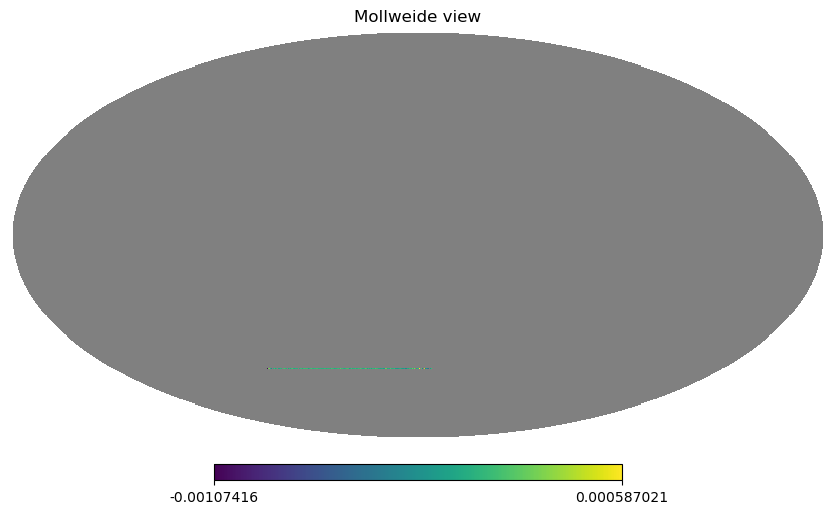

In [155]:
hp.mollview(noise_mask)

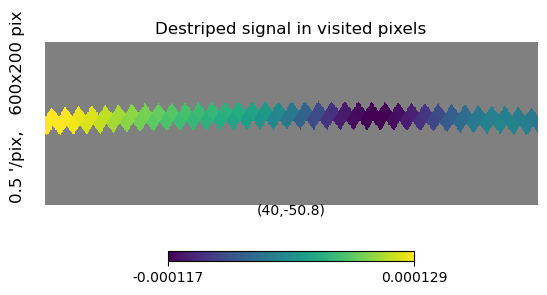

In [156]:
hp.gnomview(signal_mask,rot = (40,-50.8),xsize = 600,ysize=200,reso = .5,   title = 'Destriped signal in visited pixels')

In [157]:
hit_pix = np.nonzero(hit_map!=0)

In [158]:
hit_pix[0].shape

(905,)

In [159]:
hit_ang = hp.pix2ang(nside=  NSIDE,ipix = hit_pix[0],lonlat=True)

In [160]:
def modulo_180(x):
    if x>180:
        return (x-360)
    else:
        return x

In [161]:
modulo_180_vec = np.vectorize(modulo_180)

In [162]:
modulo_180_vec(hit_ang[0])

array([69.25531915, 69.46808511, 69.68085106, 69.89361702, 70.10638298,
       70.31914894, 70.53191489, 70.74468085, 70.95744681, 71.17021277,
       71.38297872, 71.59574468, 71.80851064, 72.0212766 , 72.23404255,
       72.44680851, 72.65957447, 72.87234043, 73.08510638, 73.29787234,
       73.5106383 , 73.72340426, 73.93617021, 74.14893617, 74.36170213,
       74.57446809, 74.78723404, 75.        , 75.21276596, 75.42553191,
       75.63829787, 75.85106383, 76.06382979, 76.27659574, 76.4893617 ,
       76.70212766, 76.91489362, 77.12765957, 77.34042553, 77.55319149,
       77.76595745, 77.9787234 , 78.19148936, 78.40425532, 78.61702128,
       78.82978723, 79.04255319, 79.25531915, 79.46808511, 79.68085106,
       79.89361702, 80.10638298, 80.31914894, 80.53191489, 80.74468085,
       80.95744681, 81.17021277, 81.38297872, 81.59574468, 81.80851064,
       82.0212766 , 82.23404255, 82.44680851, 82.65957447, 82.87234043,
       83.08510638, 83.29787234, 83.5106383 , 83.72340426, 83.93

Text(0.5, 1.0, 'First left-right scan (signal+noise)')

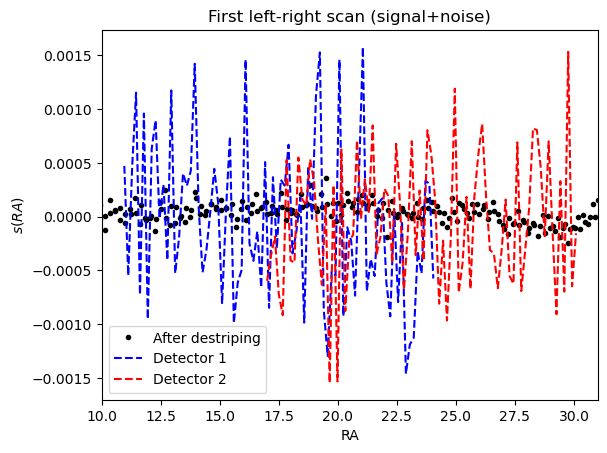

In [163]:
#plt.plot((hit_ang[0]+180)%360-180,total_destriping[hit_pix],'.')
plt.plot(modulo_180_vec(hit_ang[0]),total_destriping[hit_pix],'k.',label = 'After destriping')
#plt.plot(modulo_180_vec(hit_ang[0]),((hit_ang[0]+180)%360-180),'.')

plt.plot(np.degrees(RA_lr1scan[0][120:200]),total_lr1scan[0][120:200],'b--',label = 'Detector 1')
plt.plot(np.degrees(RA_lr2scan[0][120:200]),total_lr2scan[0][120:200],'r--',label = 'Detector 2')
plt.xlim(left = 10,right = 31)
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.legend(loc = 'lower left')
plt.title('First left-right scan (signal+noise)')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

Text(0.5, 1.0, 'First left-right scan (noise only)')

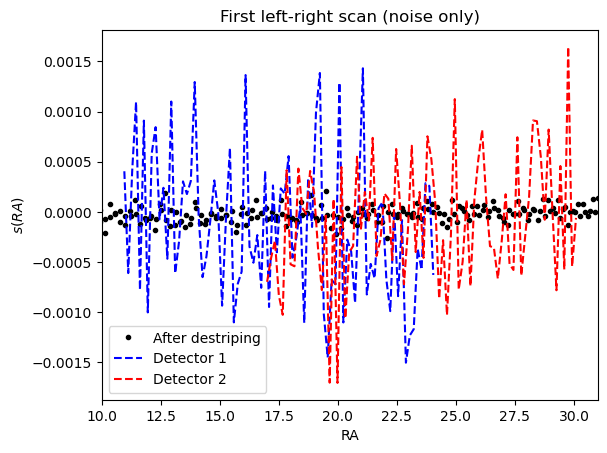

In [164]:
#plt.plot((hit_ang[0]+180)%360-180,total_destriping[hit_pix],'.')
plt.plot(modulo_180_vec(hit_ang[0]),noise_destriping[hit_pix],'k.',label = 'After destriping')
#plt.plot(modulo_180_vec(hit_ang[0]),((hit_ang[0]+180)%360-180),'.')

plt.plot(np.degrees(RA_lr1scan[0][120:200]),noise_lr1scan[0][120:200],'b--',label = 'Detector 1')
plt.plot(np.degrees(RA_lr2scan[0][120:200]),noise_lr2scan[0][120:200],'r--',label = 'Detector 2')
plt.xlim(left = 10,right = 31)
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.legend(loc = 'lower left')
plt.title('First left-right scan (noise only)')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

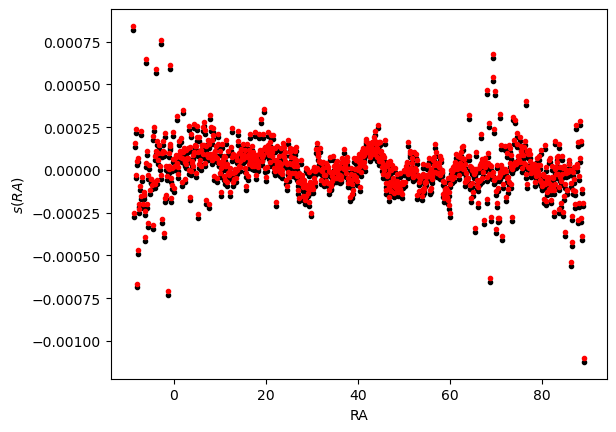

In [165]:
plt.plot(modulo_180_vec(hit_ang[0]),noise_destriping[hit_pix]+signal_destriping[hit_pix],'k.',label = 'Signal + noise')
plt.plot(modulo_180_vec(hit_ang[0]),total_destriping[hit_pix],'r.',label = 'Total')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.show()

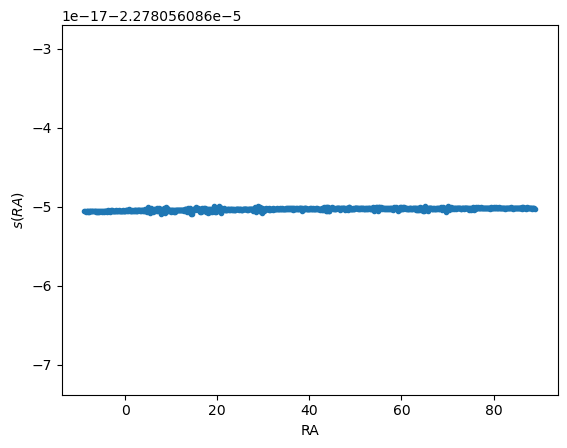

In [166]:
plt.plot(modulo_180_vec(hit_ang[0]),noise_destriping[hit_pix]+signal_destriping[hit_pix]-total_destriping[hit_pix],'.',label = 'Signal+noise-Total')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.show()

## Create a pointing matrix

Compute $P^T P$. It is block diagonal of shape $3n_{pix}^2$, with each block having the form $\begin{pmatrix}N & \sum c &\sum s \\ \sum c &\sum c^2 &\sum cs \\ \sum s &\sum cs &\sum s^2\end{pmatrix}$

In [167]:
pointing_arr = np.zeros((2*N_time,3*npix),dtype = complex)

In [134]:
pix_arr1.shape

(50400,)

In [135]:
for t in range(N_time):
    for pol in range(3):
        pointing_arr[t, pol*pix_arr1[t]] = 1
        pointing_arr[t, pol*pix_arr1[t]] = np.cos(2*psi1[t])
        pointing_arr[t, pol*pix_arr1[t]] = np.sin(2*psi1[t])
        pointing_arr[2*t, pol*pix_arr2[t]] = 1
        pointing_arr[2*t, pol*pix_arr2[t]] = np.cos(2*psi2[t])
        pointing_arr[2*t, pol*pix_arr2[t]] = np.sin(2*psi2[t])

In [136]:
pointing_arr.shape

(100800, 9437184)

In [137]:
3*npix

9437184

In [138]:
print(pointing_arr)

[[-0.76154032+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.64592935+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.64594729+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.76739286+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]]


# Hit maps

/global/homes/j/jtanglbl/.conda/envs/toastdev/lib/python3.9/site-packages/healpy/projector.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


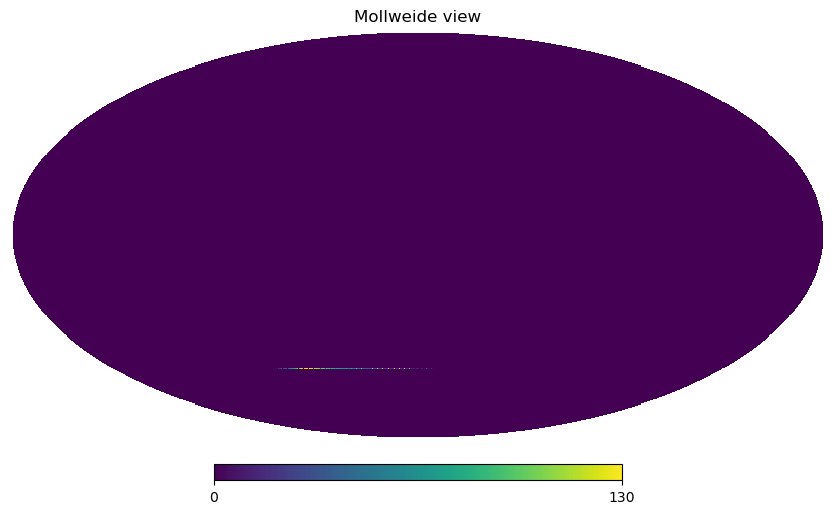

In [139]:
hitmap1 = np.zeros(npix,dtype = complex)

for pix in pix_arr1:
    hitmap1[pix]+=1
#hitmap1[hitmap1==0] = hp.UNSEEN
hp.mollview(hitmap1)

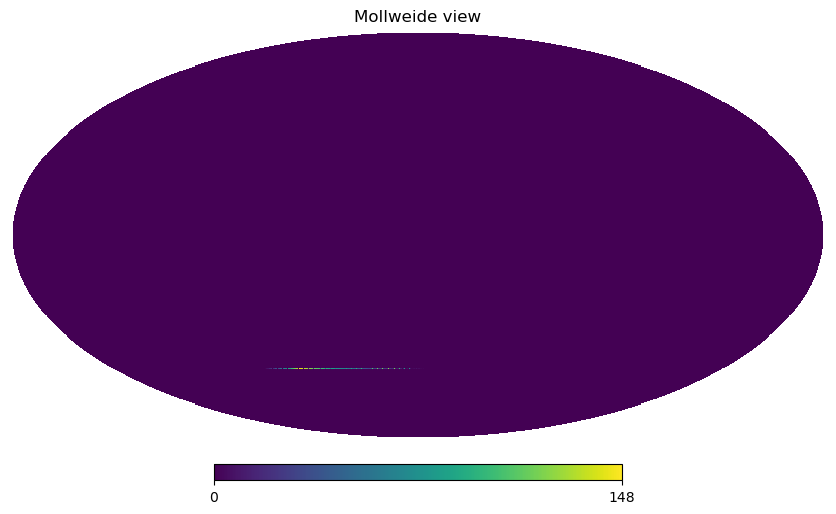

In [140]:
hitmap2 = np.zeros(npix,dtype = complex)

for pix in pix_arr2:
    hitmap2[pix]+=1
#hitmap2[hitmap2==0] = hp.UNSEEN

hp.mollview(hitmap2)

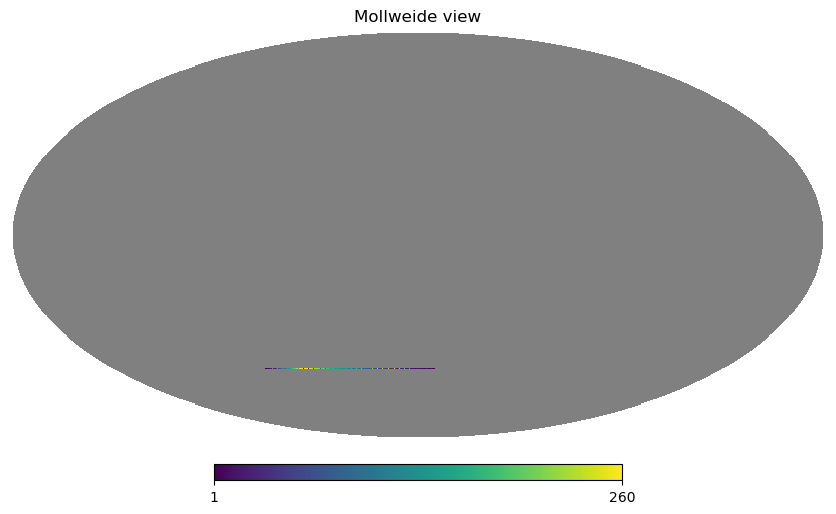

In [141]:
hitmap_tot = hitmap1+hitmap2
hitmap_tot[hitmap_tot==0] = hp.UNSEEN
hp.mollview(hitmap_tot)

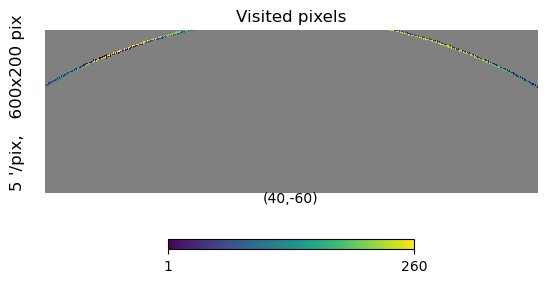

In [142]:
hp.gnomview(hitmap_tot,rot = (40,-60),xsize = 600,ysize=200,reso = 5,   title = 'Visited pixels')

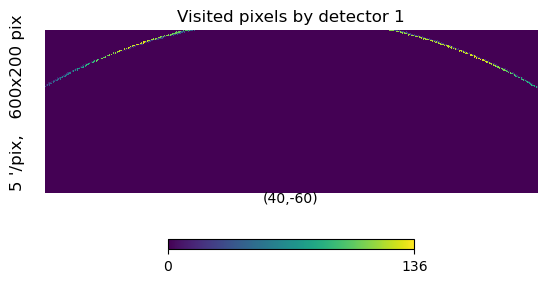

In [143]:
hp.gnomview(hitmap1,rot = (40,-60),xsize = 600,ysize=200,reso = 5,   title = 'Visited pixels by detector 1')

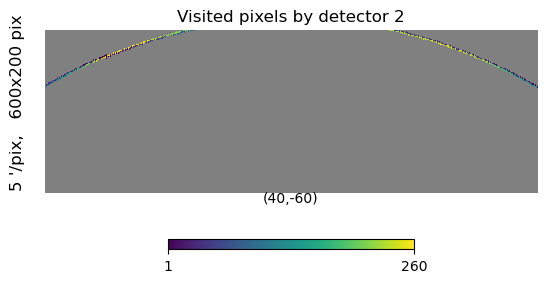

In [144]:
hp.gnomview(hitmap_tot,rot = (40,-60),xsize = 600,ysize=200,reso = 5,   title = 'Visited pixels by detector 2')

In [145]:
t_arr = np.arange(0,1000)

In [146]:
100%7

2

In [147]:
def triangle(N, t1,t2,slope):
    resul = np.zeros(N)
    for i in range(N-1):
        q = i//t2
        r = i%t2
        if r<t1:
            resul[i+1] = resul[i]+slope
        else : 
            resul[i+1] = resul[i]-slope
    return(resul)

In [148]:
res_arr = triangle(1000,35,60,3)

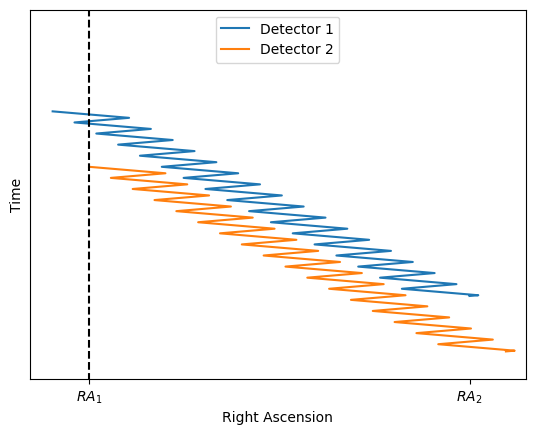

In [149]:
plt.plot(res_arr,-t_arr-550,label = 'Detector 1')
plt.plot(res_arr+50,-t_arr-850,label = 'Detector 2')
plt.vlines(x=50,ymin = -3000, ymax = 1000,colors='k', linestyles='--')
plt.legend(loc = 'upper center')
plt.xlabel('Right Ascension')
plt.ylabel('Time')
plt.xlim(right = 650)
plt.ylim(top = 0,bottom = -2000)
plt.yticks([])
plt.xticks([50,res_arr[-1]],['$RA_1$','$RA_2$'])
plt.savefig('schema_principe.pdf')